# Logistic Regression

In [16]:
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [3]:
%store -r final_df
final_df

,Temp,Humidity,Wind,Rain,ISI,Actual Fire
0,8.2,51.0,6.7,0.0,5.1,0.0
1,18.0,33.0,0.9,0.0,6.7,0.0
2,14.6,33.0,1.3,0.0,6.7,0.0
3,8.3,97.0,4.0,0.2,9.0,0.0
4,11.4,99.0,1.8,0.0,9.6,0.0
...,...,...,...,...,...,...
756,30.0,65.0,14.0,0.0,4.5,1.0
757,28.0,87.0,15.0,4.4,0.1,0.0
758,27.0,87.0,29.0,0.5,0.4,0.0
759,24.0,54.0,18.0,0.1,1.7,0.0


## Assumptions
The code below is to verify for logistic regression assumptions. These assumptions include:
- No multicollinearity
- Independence of cases
- Non-Linearity
- No outliers

In [4]:
final_df['Actual Fire'].value_counts()

1.0    407
0.0    353
Name: Actual Fire, dtype: int64

In [5]:
final_df_remove_outliers = final_df[(np.abs(zscore(final_df)) < 3).all(axis=1)]

final_df.index.difference(final_df_remove_outliers.index)

Int64Index([ 11,  22, 266, 499, 519, 608, 609, 610, 621, 622, 633, 640, 655,
            656, 657, 676, 735, 736, 757, 758],
           dtype='int64')

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
def create_vif(dataframe):
    ''' This function calculates the Variation Inflation Factors for each column and convert it into a dataframe'''
    
    #create an empty dataframe
    vif_table = pd.DataFrame()
    #populate the first column with the columns of the dataset
    vif_table['variables'] = dataframe.columns
    #calculate the VIF of each column and create a VIF column to store the number
    vif_table['VIF'] = [vif(dataframe.values, i) for i in range(dataframe.shape[1])]
    
    return vif_table

#print the VIF table for each variable
print(create_vif(final_df_remove_outliers))

     variables        VIF
0         Temp  13.033657
1     Humidity   5.554918
2         Wind   6.983634
3         Rain   1.366429
4          ISI   4.581002
5  Actual Fire   2.506154


In [6]:
feature_cols = ['Temp', 'Humidity', 'Wind', 'Rain']
X = final_df_remove_outliers[feature_cols]
Y = final_df_remove_outliers['Actual Fire']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25, random_state=0)

In [7]:
#instantiate the model
log_regression = LogisticRegression()

#fit the model using the training data
log_regression.fit(X_train,Y_train)

#use model to make predictions on test data
y_pred = log_regression.predict(X_test)

In [8]:
cnf_matrix = metrics.confusion_matrix(Y_test, y_pred)
cnf_matrix

array([[35, 45],
       [24, 81]], dtype=int64)

In [9]:
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.6270270270270271


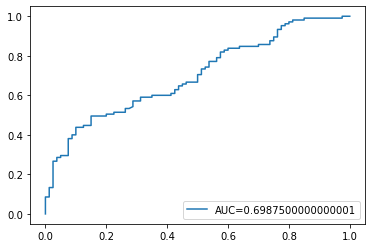

In [10]:
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_test,  y_pred_proba)
auc = metrics.roc_auc_score(Y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.show()